# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np 
import json
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore
from scipy import stats

In [2]:
# Load dataframe created in data wrangling phase
# Parse datetime column and make index
df= pd.read_csv('cleaned_cov_weather4.csv', parse_dates=['date'], index_col ='date')

In [3]:
df.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,-28,0,-72.0,0.0,-76.0,0.0,-53.0,0.0,0,0,0,0
2020-01-23,-27,0,-30.0,3.0,-46.0,0.0,0.0,0.0,0,0,0,0
2020-01-24,-8,0,-14.0,0.0,6.0,0.0,19.0,0.0,0,0,0,0
2020-01-25,3,119,-30.0,3.0,23.0,218.0,33.0,25.0,0,0,0,0
2020-01-26,22,23,11.0,132.0,49.0,0.0,64.0,193.0,0,0,0,0


In [4]:
# Check for duplicated DateTimeIndices
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-30,61,170,53.0,503.0,57.0,478.0,80.0,122.0,117295,11757,226132,4172


In [5]:
# Remove duplicated DateTimeIndices (but keep first instances of indices)
# Check to confirm duplicated indices have been removed 
df = df[~df.index.duplicated(keep='first')]
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


In [6]:
# double check data types
df.dtypes

vt_avg_temp        int64
vt_prcp            int64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases      int64
ME_conf_cases      int64
MA_conf_cases      int64
VT_conf_cases      int64
dtype: object

In [7]:
# Convert int columns to float in preparation for calculations:
int_columns= {"CT_conf_cases": 'float', "ME_conf_cases": 'float', "MA_conf_cases":"float", "VT_conf_cases":'float', "vt_avg_temp":'float', "vt_prcp":'float'}
df = df.astype(int_columns)

In [8]:
df.dtypes

vt_avg_temp      float64
vt_prcp          float64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases    float64
ME_conf_cases    float64
MA_conf_cases    float64
VT_conf_cases    float64
dtype: object

In [9]:
# Any missing values?
df[pd.isnull(df).any(axis=1)]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


No missing values.

However, the units of TAVG and PRCP are clearly off. 

According to [NOAA documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), temperatures are reported in __*tenths*__ of a degree Celsius. I'll convert to degrees Fahrenheit instead (since this is US data here).

In [10]:
# (C*9/50)+32=F (since C is reported here as tenths of degrees)
df2=df
df2['vt_avg_temp'] = ((df['vt_avg_temp']*9)/50) + 32
df2['me_avg_temp'] = ((df['me_avg_temp']*9)/50) + 32
df2['ct_avg_temp'] = ((df['ct_avg_temp']*9)/50) + 32
df2['ma_avg_temp'] = ((df['ma_avg_temp']*9)/50) + 32

The [same documention](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) cited above also explains that PRCP data is reported in __*tenths*__ of a mm. [Wikipedia](https://en.wikipedia.org/wiki/Precipitation) reports that generally PRCP data is reported in millimeters, so I'll convert to millimeters instead.

In [11]:
df3=df2
df3['vt_prcp'] = df2['vt_prcp']/10
df3['me_prcp'] = df2['me_prcp']/10
df3['ct_prcp'] = df2['ct_prcp']/10
df3['ma_prcp'] = df2['ma_prcp']/10

In [12]:
df3.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


For the sake of clarity, I'll update column names to reflect this unit change.

In [13]:
#Update column names to reflect new units:
units_dict= {'vt_avg_temp': 'VT_Avg_Temp(F)', 'vt_prcp': 'VT_PRCP(mm)', 'me_avg_temp':'ME_Avg_Temp(F)', 'me_prcp': 'ME_PRCP(mm)', 'ct_avg_temp': 'CT_Avg_Temp(F)', 'ct_prcp':'CT_PRCP(mm)', 'ma_avg_temp': 'MA_Avg_Temp(F)', 'ma_prcp':'MA_PRCP(mm)'}
df3.rename(columns=units_dict, inplace=True)
df3.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


In [14]:
#Examine timespan of data:
print('Beginning date: ',min(df3.index))
print('End date: ', max(df3.index))
print('Total timespan: ', max(df3.index-min(df3.index)))

Beginning date:  2020-01-22 00:00:00
End date:  2021-09-12 00:00:00
Total timespan:  599 days 00:00:00


In [15]:
# Make copy of df 
df4=df3

The confirmed cases column represented total number of cumulative new COVID cases per date. To explore new infection *rates* over time, rather than cumulative COVID cases, we'll have to take the first differences of the cumulative counts. There shouldn't be any `NaN`s left, but just in case, we'll chain the `.fillna()` method to the end of our first differences calls.

In [16]:
# Make column of non-cumulative counts of confirmed cases for each state:
df4["CT_Conf_Cases"] = df4['CT_conf_cases'].diff().fillna(0)
df4["VT_Conf_Cases"] = df4['VT_conf_cases'].diff().fillna(0)
df4["ME_Conf_Cases"] = df4['ME_conf_cases'].diff().fillna(0)
df4["MA_Conf_Cases"] = df4['MA_conf_cases'].diff().fillna(0)

In [17]:
# Drop cumulative confirmed case columns:
df5 = df4.drop(columns=['CT_conf_cases', 'VT_conf_cases', 'ME_conf_cases', 'MA_conf_cases'])

In [18]:
# Take a look at some summary statistics of the data:
# First, we'll define a function to highlight any negative values (as we can't have negative new COVID case values)
def highlight_neg(cell):
    if cell < 0 :
        return 'background: yellow'  
df5.describe().style.applymap(highlight_neg)

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,51.115400,2.239833,45.224000,2.853500,54.263300,3.502333,54.381950,3.787833,631.555000,50.190000,134.188333,1295.036667
std,19.936095,5.804667,19.548057,8.950529,17.516293,10.068826,16.950279,10.299207,1110.107736,63.347234,171.873540,1568.531084
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,-15.000000,-1.000000,-1.000000,-280.000000
25%,35.060000,0.000000,30.020000,0.000000,39.155000,0.000000,39.920000,0.000000,0.000000,3.000000,18.000000,200.750000
50%,51.980000,0.000000,46.760000,0.000000,55.580000,0.000000,55.040000,0.000000,165.500000,13.500000,42.000000,658.500000
75%,68.000000,1.300000,62.150000,1.300000,70.160000,1.300000,68.630000,2.000000,738.750000,94.000000,211.000000,1884.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,9003.000000


The negative value in `ME_Avg_Temp(F)` column is fine, however it looks like some of the states have `Conf_Cases` values that are less than zero. That can't be right; this needs to be looked into. Let's first see how many negative values are in each state's confirmed case counts and how large or small the values are. These will be considerations when we decide how to best address them.

In [19]:
CT_neg = df5[df5['CT_Conf_Cases']<0]
print("CT has", len(CT_neg), "negative case value(s):")
print(CT_neg.CT_Conf_Cases)

CT has 2 negative case value(s):
date
2020-05-27   -15.0
2020-08-18   -12.0
Name: CT_Conf_Cases, dtype: float64


In [20]:
VT_neg = df5[df5['VT_Conf_Cases']<0]
print("VT has", len(VT_neg), "negative case value(s):")
print(VT_neg.VT_Conf_Cases)

VT has 2 negative case value(s):
date
2020-05-11   -1.0
2020-06-17   -1.0
Name: VT_Conf_Cases, dtype: float64


In [21]:
ME_neg = df5[df5['ME_Conf_Cases']<0]
print("ME has", len(ME_neg), "negative case value(s):")
print(ME_neg.ME_Conf_Cases)

ME has 4 negative case value(s):
date
2020-03-15   -1.0
2020-07-22   -1.0
2020-09-09   -1.0
2021-08-09   -1.0
Name: ME_Conf_Cases, dtype: float64


In [22]:
MA_neg = df5[df5['MA_Conf_Cases']<0]
print("MA has", len(MA_neg), "negative case value(s):")
print(MA_neg.MA_Conf_Cases)

MA has 1 negative case value(s):
date
2020-09-03   -280.0
Name: MA_Conf_Cases, dtype: float64


Connecticut has two negative case counts, Vermont also has two negative case counts, Maine has four negative case counts, and Massachusetts has one negative case count (for a total of 9 negative case counts). Thankfully we don't have *a lot* of these erroneous counts, but before blindly filling them all with zeroes, let's check to see what the case counts around these dates look like. If they're very low, we may be able to fill the negtive values with zeroes without much impact. If these values occur during a surge, however, we may need to look a little deeper. 

In [23]:
# Print day before and after each negative case value in CT:
ct_neg_df = pd.DataFrame(pd.concat([df5['2020-05-26':'2020-05-28'].CT_Conf_Cases, 
                                    df5['2020-08-17':'2020-08-19'].CT_Conf_Cases]))
ct_neg_df.style.applymap(highlight_neg)

,CT_Conf_Cases
date,
2020-05-26 00:00:00,430.000000
2020-05-27 00:00:00,-15.000000
2020-05-28 00:00:00,271.000000
2020-08-17 00:00:00,370.000000
2020-08-18 00:00:00,-12.000000
2020-08-19 00:00:00,59.000000


In [24]:
# Print day before and after each negative case value in VT:
vt_neg_df = pd.DataFrame(pd.concat([df5['2020-05-10':'2020-05-12'].VT_Conf_Cases, 
                                    df5['2020-06-16':'2020-06-18'].VT_Conf_Cases]))
vt_neg_df.style.applymap(highlight_neg)

,VT_Conf_Cases
date,
2020-05-10 00:00:00,6.000000
2020-05-11 00:00:00,-1.000000
2020-05-12 00:00:00,1.000000
2020-06-16 00:00:00,3.000000
2020-06-17 00:00:00,-1.000000
2020-06-18 00:00:00,5.000000


In [25]:
# Print day before and after each negative case value in ME:
me_neg_df = pd.DataFrame(pd.concat([df5['2020-03-14':'2020-03-16'].ME_Conf_Cases, 
                                    df5['2020-07-21':'2020-07-23'].ME_Conf_Cases, 
                                    df5['2020-09-08':'2020-09-10'].ME_Conf_Cases, 
                                    df5['2021-08-08':'2021-08-10'].ME_Conf_Cases]))
me_neg_df.style.applymap(highlight_neg)

,ME_Conf_Cases
date,
2020-03-14 00:00:00,0.000000
2020-03-15 00:00:00,-1.000000
2020-03-16 00:00:00,15.000000
2020-07-21 00:00:00,12.000000
2020-07-22 00:00:00,-1.000000
2020-07-23 00:00:00,15.000000
2020-09-08 00:00:00,13.000000
2020-09-09 00:00:00,-1.000000
2020-09-10 00:00:00,47.000000


In [26]:
# Print day before and after each negative case value in MA:
ma_neg_df = pd.DataFrame(pd.concat([df5['2020-09-02':'2020-09-04'].MA_Conf_Cases]))
ma_neg_df.style.applymap(highlight_neg)

,MA_Conf_Cases
date,
2020-09-02 00:00:00,404.000000
2020-09-03 00:00:00,-280.000000
2020-09-04 00:00:00,212.000000


If Vermont was the only state with negative case counts, it may be alright to fill negative case counts with zeroes, but all other states would likely be adversely affected by this. For example, Massachusetts has a case count value of -280, between dates with case counts of positive 404 and 212. Maine, too, has a value of -1 right before a value of 361 cases (which is a large case count for this less-populous state). Therefore, let's replace these negative case count values with the average of the case counts of the date before and after them. To do this, we'll first convert the negative values to `NaN`s, and then we'll use the `.fillna()` method. 

In [27]:
# Replace cases negative values with np.nan
df5.MA_Conf_Cases['2020-09-03'] = np.nan
df5.CT_Conf_Cases[['2020-05-27', '2020-08-18']] = np.nan
df5.VT_Conf_Cases[['2020-05-11', '2020-06-17']] = np.nan
df5.ME_Conf_Cases[['2020-03-15','2020-07-22', '2020-09-09', '2021-08-09']]= np.nan

In [28]:
# Loop through NaNs and fill with average of previous and following cell values 
state_col_list=['CT_Conf_Cases', 'VT_Conf_Cases', 'ME_Conf_Cases', 'MA_Conf_Cases']
for col in state_col_list:
    df5[col] = df5[col].fillna((df5[col].shift() + df5[col].shift(-1))/2)

Now all of the negative case values should have been replaced with the average of the value preceding and following it. Let's double check the summary statistics of the full DataFrame just to make sure everything looks good.

In [29]:
 df5.describe().style.applymap(highlight_neg)

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,51.115400,2.239833,45.224000,2.853500,54.263300,3.502333,54.381950,3.787833,632.541667,50.205833,134.580833,1296.016667
std,19.936095,5.804667,19.548057,8.950529,17.516293,10.068826,16.950279,10.299207,1109.671640,63.335011,171.729819,1567.728859
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,30.020000,0.000000,39.155000,0.000000,39.920000,0.000000,0.000000,3.000000,19.000000,202.500000
50%,51.980000,0.000000,46.760000,0.000000,55.580000,0.000000,55.040000,0.000000,169.500000,13.500000,42.000000,658.500000
75%,68.000000,1.300000,62.150000,1.300000,70.160000,1.300000,68.630000,2.000000,738.750000,94.000000,211.000000,1884.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,9003.000000


Now there are no more negative COVID case counts in the DataFrame; the only negative values belong to an average temperature column (which makes sense- Maine gets pretty cold in the winter!).

A quick look at the tail of the DataFrame reveals another interesting detail, however.

In [30]:
# Define a function to highlight zero values (which may be indicative of missing values)
def highlight_zero(cell):
    if cell == 0:
        return 'background: yellow'  

In [31]:
(pd.DataFrame(df5['CT_Conf_Cases'].tail(25))).style.applymap(highlight_zero)

,CT_Conf_Cases
date,
2021-08-19 00:00:00,534.000000
2021-08-20 00:00:00,431.000000
2021-08-21 00:00:00,0.000000
2021-08-22 00:00:00,0.000000
2021-08-23 00:00:00,1554.000000
2021-08-24 00:00:00,1071.000000
2021-08-25 00:00:00,651.000000
2021-08-26 00:00:00,788.000000
2021-08-27 00:00:00,788.000000


Zeroes are sometimes, but not always, indicative of missing values. We would probably expect a certain proportion of zero values for confirmed cases in a dataset like ours, but the above highlighted values follow a pretty clear pattern (which is suspicious). For every five days of values for `Conf_Cases`, there are two days of zero values. It seems that values have not been recorded for weekends dates in Connecticut, and a quick calendar check confirms the above highlighted zero values all correspond to weekend dates. But what about Monday 2021-09-06? The calendar shows that this was [Labor Day](https://www.officeholidays.com/countries/usa/2021), a bank holiday in the US.


Let's check if the other states follow Connecticut's case reporting schedule, or some other schedule entirely. Before we do that, though, let's add a column, `weekday`, indicating the day of the week for each row of data.

In [32]:
df6= df5
# Add a weekday column
df6["weekday"] = df5.index.dayofweek

In [33]:
# Compare all states' missing value patterns
(pd.DataFrame(df5[['CT_Conf_Cases', 'MA_Conf_Cases', 'ME_Conf_Cases', 
                            'VT_Conf_Cases', 'weekday']].tail(25)).style.applymap(highlight_zero))

,CT_Conf_Cases,MA_Conf_Cases,ME_Conf_Cases,VT_Conf_Cases,weekday
date,,,,,
2021-08-19 00:00:00,534.000000,1576.000000,182.000000,169.000000,3
2021-08-20 00:00:00,431.000000,1533.000000,185.000000,115.000000,4
2021-08-21 00:00:00,0.000000,0.000000,205.000000,146.000000,5
2021-08-22 00:00:00,0.000000,0.000000,0.000000,126.000000,6
2021-08-23 00:00:00,1554.000000,3418.000000,0.000000,82.000000,0
2021-08-24 00:00:00,1071.000000,1600.000000,362.000000,105.000000,1
2021-08-25 00:00:00,651.000000,1495.000000,291.000000,118.000000,2
2021-08-26 00:00:00,788.000000,1891.000000,390.000000,149.000000,3
2021-08-27 00:00:00,788.000000,1656.000000,263.000000,144.000000,4


From the above data, it looks like Massachusetts and Connecticut may have similar Monday-Friday reporting schedules. It also seems that Maine may report cases Tuesday-Saturday and Vermont may report cases seven days a week (at least for these last 25 rows). Three out of four of the states also reported zero values for 2021-09-06 (a Monday) which we've already determined was a US bank holiday. Notably, Vermont did report cases on this date however.

It's clear that each state's reporting schedule varies, and also that there may be some unsual exceptions to these schedules (like bank holidays) for some states. Clearly we'll need to investigate each state's individual reporting schedule more closely. We may get a better idea of the overall distribution and pattern of these zero values by representing them visually. 

Below I plot each state's daily new confirmed case counts. In the plots for Massachusetts, Connecticut, and Vermont, there is an orange vertical line for every zero value that falls on a Saturday, a red vertical line for every zero value that falls on a Sunday, and a green vertical line for every zero value that falls on any day of the week other than Saturday or Sunday.

Because Maine seems to follow a different schedule, I've placed a red vertical line for every zero count that falls on *Sunday*, an orange vertical line for every zero value that falls on a *Monday*, and a green vertical line for every zero value that falls on any day of the week other than Sunday or Monday.

By plotting the orange and red lines, we'll be able to check our hypothesis regarding each state's reporting schedule. By plotting the green lines, we'll be able to double check for any unusual cases of zero values that do not fit within our hypothesized reporting schedules.

In [34]:
df7 = df6
sunday_ind_me=(df7[(df7.weekday == 6)&(df7.ME_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
monday_ind_me=(df7[(df7.weekday == 0)&(df7.ME_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Monday zero values
# Zero values that are neither Sunday nor Monday
other_ind_me=(df7[(df7.weekday != 0)& (df7.weekday != 6)&(df7.ME_Conf_Cases==0)& (df7.index >'2020-01-29')]).index  

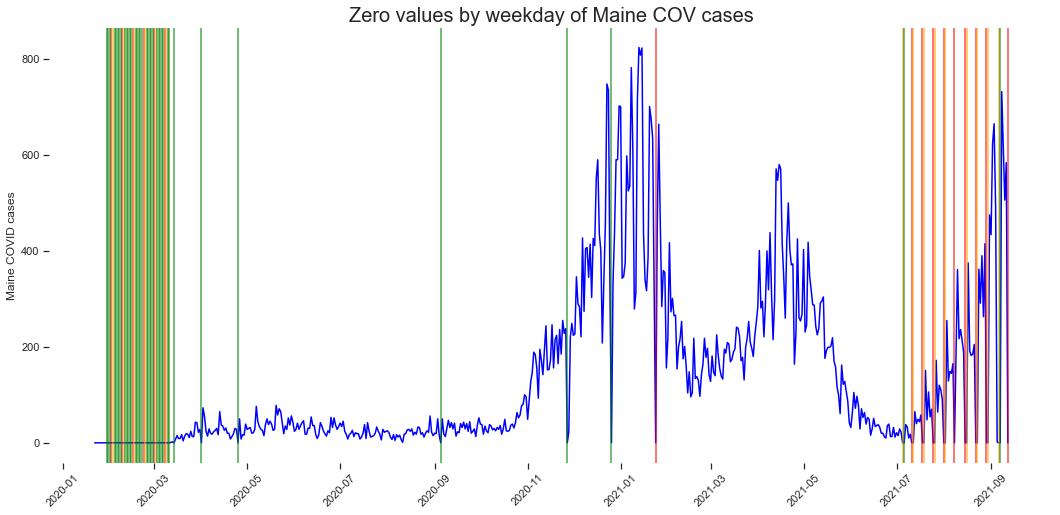

In [35]:
sns.set(rc={'figure.figsize':(18,8)})
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['ME_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Maine COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_me:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in monday_ind_me:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_me:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Maine COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

It seems that (with a few individual exceptions), Maine actually reported new case counts every day of the week until around July of 2021. This means that **we'll only need to address Sunday-Monday zero case counts for Maine from July of 2021 onwards.** We can also look into the few exceptions (green lines) that occur prior to July, 2021, and check for bank holidays. We can also see that Maine did not report it's first COVID case until March of 2020.

In [36]:
sunday_ind_ma=(df7[(df7.weekday == 6)&(df7.MA_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_ma=(df7[(df7.weekday == 5)&(df7.MA_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ma=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.MA_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

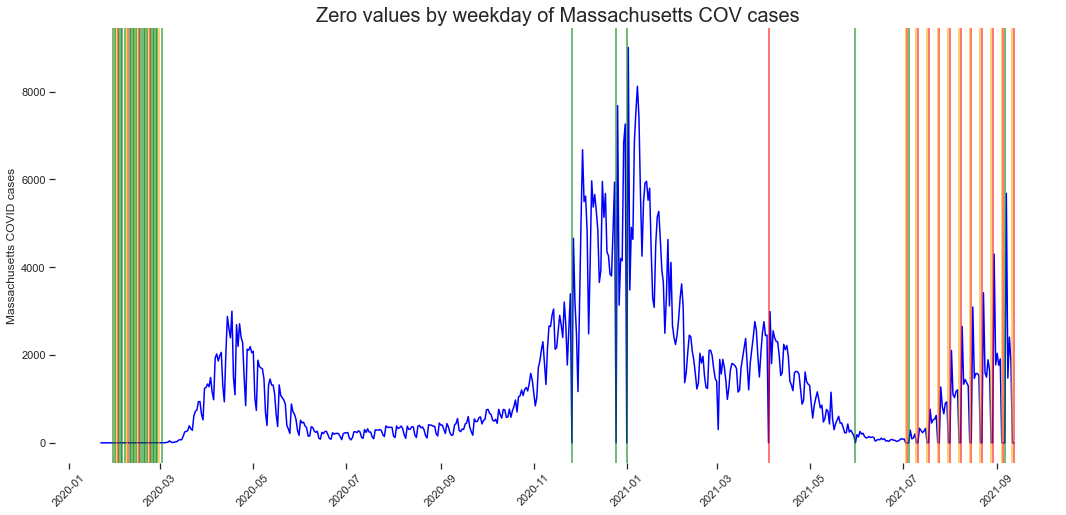

In [37]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['MA_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Massachusetts COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ma:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ma:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ma:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Massachusetts COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

It looks like Massachusetts was also reporting case counts daily (seven days a week) until around July of 2021 (when it switched to a Monday-Friday reporting schedule). We can also examine the few exceptions (green lines) for Massachusetts, but it looks like **we'll only need to examine Saturday-Sunday zero case values for Massachusetts from July, 2021 onwards** also. We can see that Massachusetts hasn't reported any significant case values until around March of 2020 either. We may want to further slice our data to begin in March, 2020 to avoid skewing our data with these zero values, but let's first check the Connecticut and Vermont case counts to make sure we aren't dropping any useful data.

In [38]:
sunday_ind_ct=(df7[(df7.weekday == 6)&(df7.CT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_ct=(df7[(df7.weekday == 5)&(df7.CT_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ct=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.CT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

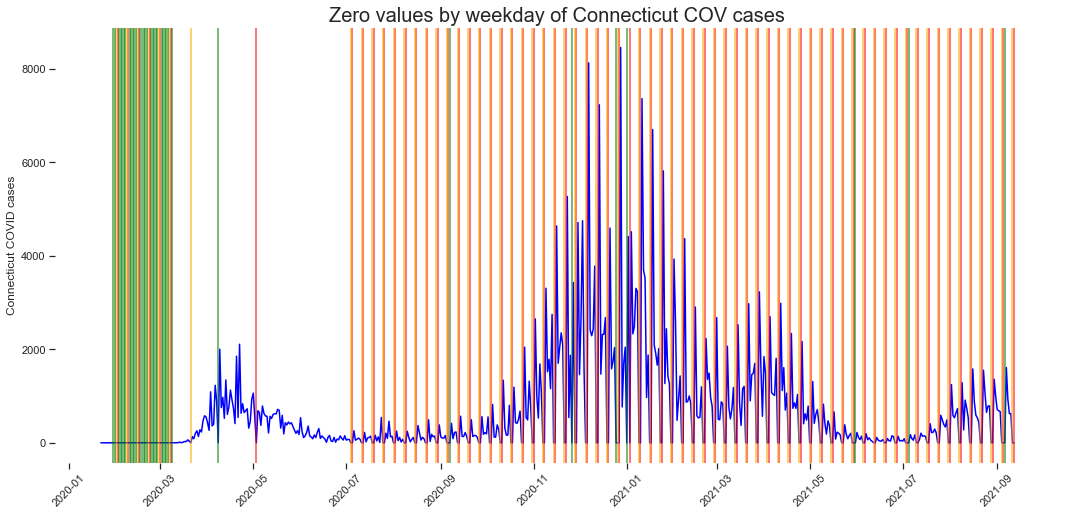

In [39]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['CT_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Connecticut COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ct:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ct:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ct:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Connecticut COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

Connecticut clearly has a very different reporting schedule than Massachusetts and Maine. It looks like Connecticut only reported case counts seven days a week until around July of *2020*. **We'll need to address Saturday-Sunday zero value counts for Connecticut from July, *2020* onwards.** Connecticut also seems to have reported it's first COVID case sometime in March of 2020.

In [40]:
sunday_ind_vt=(df7[(df7.weekday == 6)&(df7.VT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_vt=(df7[(df7.weekday == 5)&(df7.VT_Conf_Cases==0)&(df7.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df7[(df7.weekday != 5)& (df7.weekday != 6)&(df7.VT_Conf_Cases==0)& (df7.index >'2020-01-29')]).index 

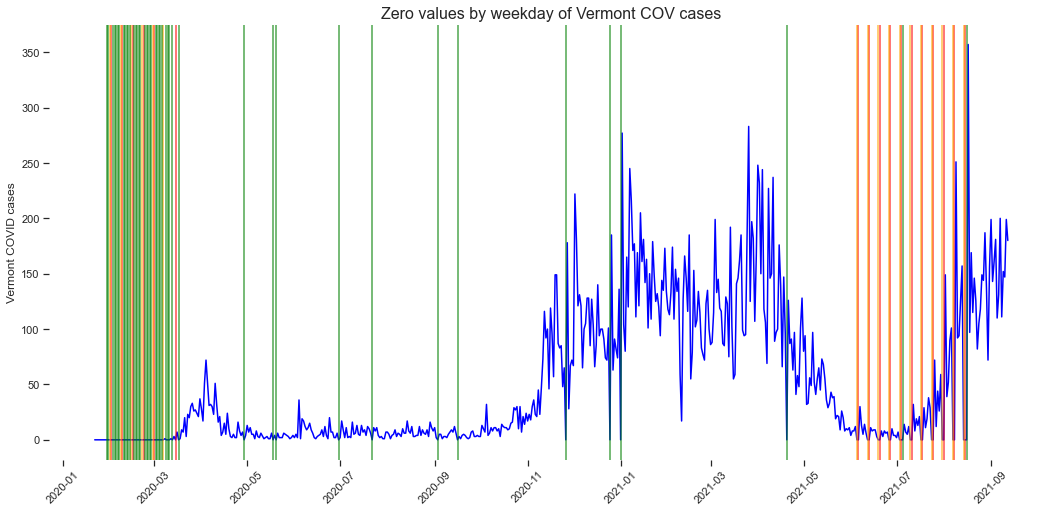

In [41]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df7.index, df7['VT_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=16)
    sns.despine(left=True, bottom=True)
    plt.show()

Vermont seems only to have followed a Monday-Friday reporting schedule for about 2-3 months, from around June of 2021 until August 2021, before reverting back to daily reporting. **We'll need to address Saturday-Sunday zero case values for Vermont from June 2021- August 2021.** Vermont also didn't report its first COVID case until sometime in March of 2020.

It seems pretty clear that we can cut all data prior to March 2020 as we only have 1 non-zero value count (from Massachusetts) prior to March, and so the repetetive zero values from this period can only serve to skew our data. 

In [42]:
# Cut data from before March of 2020
df8=df7.loc['2020-03-01':]

Let's check out how one of the plots looks after the slicing:

In [43]:
sunday_ind_vt=(df8[(df8.weekday == 6)&(df8.VT_Conf_Cases==0)& (df8.index >'2020-01-29')]).index # Sunday zero values
saturday_ind_vt=(df8[(df8.weekday == 5)&(df8.VT_Conf_Cases==0)&(df8.index>'2020-01-29')]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df8[(df8.weekday != 5)& (df8.weekday != 6)&(df8.VT_Conf_Cases==0)& (df8.index >'2020-01-29')]).index 

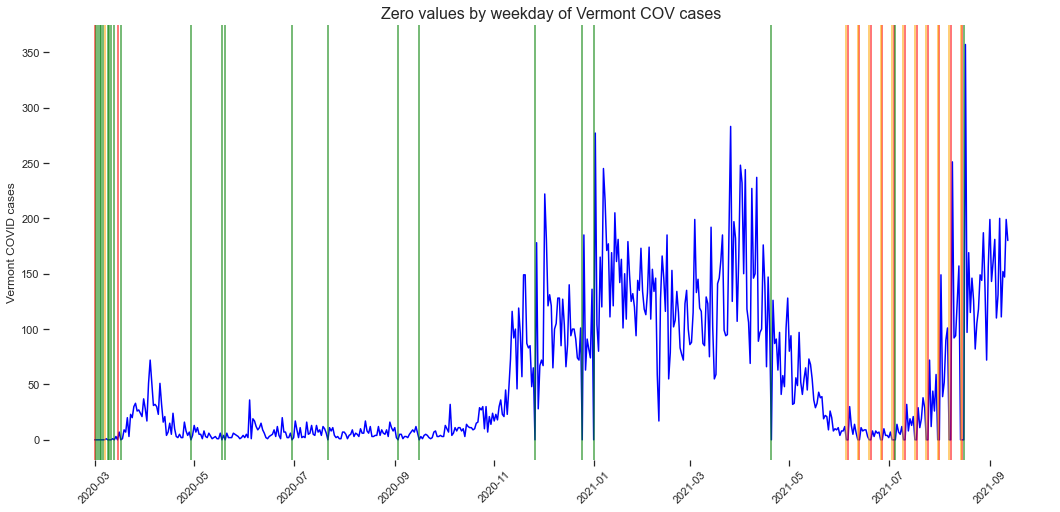

In [44]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df8.index, df8['VT_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=16)
    sns.despine(left=True, bottom=True)
    plt.show()

This looks a lot better! 

Now we'll need to address each state's unique reporting schedule. 
By examining each state governments' webpages (see here: [Maine](https://www.maine.gov/dhhs/mecdc/infectious-disease/epi/airborne/coronavirus/data.shtml), [Massachusetts](https://www.mass.gov/info-details/covid-19-response-reporting), [Vermont](https://www.healthvermont.gov/covid-19), [Connecticut](https://portal.ct.gov/coronavirus/covid-19-data-tracker)), we can confirm the apparent trends in the plots above. From [this Associated Press article](https://apnews.com/article/health-coronavirus-pandemic-vermont-c781aa063d30e8f665500deaf8902ab9) we can also confirm that Vermont resumed daily case reporting on 2021-08-23 (due to a surge in cases).

More simply, each state reported cases daily, besides the following periods (and a few select bank holidays):

* **Maine** reported cases **Tuesday-Saturday** from **2021-07-01 onwards**.
* **Massachusetts** reported cases **Monday-Friday** from **2021-07-01 onwards**.
* **Connecticut** reported cases **Monday-Friday** from **2020-07-01 onwards**.
* **Vermont** reported cases **Monday-Friday** from **2021-06-01 to 2021-08-23**.

The above hyperlinked resources also describe that each state reports a cumulative total of new cases on the day following a two-day break in reporting. For Massachusetts, Connecticut, and Vermont, this would be Monday. For Maine this would be Tuesday. The resources also indicate that if the day following a two-day break in reporting (either Monday or Tuesday) is a bank holiday, then a cumulative case count for the *three* prior days will be reported on the day following the bank holiday (for Massachusetts, Connecticut, and Vermont, this would be Tuesday, and for Maine, this would be Wednesday).

Now that we've more clearly defined each state's reporting schedules, let's address the zero values. Because we know that each state reports a *cumulative total* the day following a break in reporting, we can divide this cumulative count by three and replace each of the three days' values with a third of the cumulative value for those days. Before doing so, we'll have to check to make sure none of these days fall on a bank holiday, however.

## Maine

For Maine, first I'll check each confirmed case count occurring on or after 2021-07-01, on a Tuesday, that does not have a zero case count (so must not be a bank holiday on which cases were not reported), and replace that value with one third of itself. Then I'll replace all zero Sunday and Monday case count values occurring on or after 2021-07-01 with `np.nan` and use `.fillna()` to backfill the `NaN`s.

In [45]:
df9=df8

In [46]:
df9.ME_Conf_Cases.loc['2021-07-07'] = round(df9.ME_Conf_Cases.loc['2021-07-07']/3)
df9.ME_Conf_Cases.loc[['2021-07-05', '2021-07-06']] = df9.ME_Conf_Cases.loc['2021-07-07']

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [47]:
# Iterate over indices, rows and if row corresponds to a Tuesday after 2021-07-01 with a non-zero value for 
# ME_Conf_Cases, append index, case value, to corresponding lists
ME_tuesday_index_list = []
ME_tuesday_case_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==1) & (row['ME_Conf_Cases'] != 0):
        ME_tuesday_index_list.append(index)
        row['ME_Conf_Cases'] = round(row['ME_Conf_Cases']/3)
        ME_tuesday_case_list.append(row['ME_Conf_Cases'])

In [48]:
ME_monday_index_list = []
ME_monday_case_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==0) & (row['ME_Conf_Cases'] == 0):
        ME_monday_index_list.append(index)

In [49]:
ME_monday_dict= dict(zip(ME_monday_index_list, ME_tuesday_case_list))

In [50]:
for key, value in ME_monday_dict.items():
    df9['ME_Conf_Cases'].loc[key] = value

In [51]:
ME_sunday_index_list = []
ME_sunday_case_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['ME_Conf_Cases'] == 0):
        ME_sunday_index_list.append(index)

In [52]:
ME_sunday_dict= dict(zip(ME_sunday_index_list, ME_tuesday_case_list))

In [53]:
for key, value in ME_sunday_dict.items():
    df9['ME_Conf_Cases'].loc[key] = value

In [54]:
sunday_ind_me=(df9[(df9.weekday == 6)&(df9.ME_Conf_Cases==0)]).index # Sunday zero values
monday_ind_me=(df9[(df9.weekday == 0)&(df9.ME_Conf_Cases==0)]).index # Monday zero values
# Zero values that are neither Sunday nor Monday
other_ind_me=(df9[(df9.weekday != 0)& (df9.weekday != 6)&(df9.ME_Conf_Cases==0)]).index

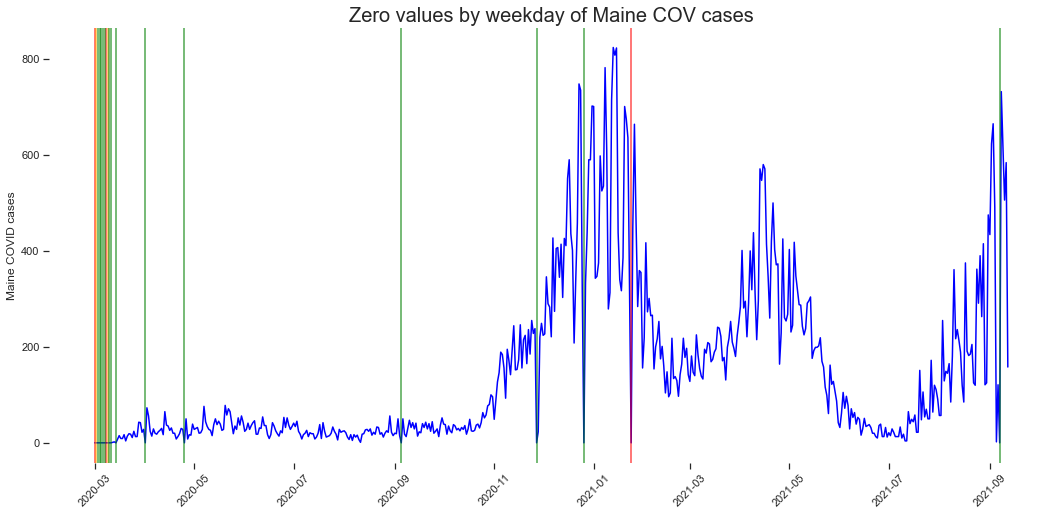

In [55]:
sns.set(rc={'figure.figsize':(18,8)})
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['ME_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Maine COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_me:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in monday_ind_me:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_me:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Maine COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

## Connecticut

#### Monday

In [56]:
CT_monday_index_list = []
CT_monday_case_list = []
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2020-07-01')) & (row['weekday']==0) &(row['CT_Conf_Cases'] != 0):
        CT_monday_index_list.append(index)
        row['CT_Conf_Cases'] = round(row['CT_Conf_Cases']/3)
        CT_monday_case_list.append(row['CT_Conf_Cases'])

#### Sunday

In [57]:
CT_sunday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-07-01')) & (row['weekday']==6) & (row['CT_Conf_Cases'] == 0):
        CT_sunday_index_list.append(index)

In [58]:
CT_sunday_dict= dict(zip(CT_sunday_index_list, CT_monday_case_list))

In [59]:
for key, value in CT_sunday_dict.items():
    df9['CT_Conf_Cases'].loc[key] = value

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Ask Raghu to look at this code: why are the last 4 values not replaced in first call (directly above)? A second call (directly below) fixes this-- but is this a sloppy solution?

In [60]:
CT_monday_index_list2 = []
CT_monday_case_list2 = []
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-08-05')) & (row['weekday']==0) &(row['CT_Conf_Cases'] != 0):
        CT_monday_index_list2.append(index)
        row['CT_Conf_Cases'] = round(row['CT_Conf_Cases']/3)
        CT_monday_case_list2.append(row['CT_Conf_Cases'])

In [61]:
CT_sunday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2020-08-08')) & (row['weekday']==6) & (row['CT_Conf_Cases'] == 0):
        CT_sunday_index_list.append(index)

In [62]:
CT_sunday_dict= dict(zip(CT_sunday_index_list, CT_monday_case_list2))

In [63]:
for key, value in CT_sunday_dict.items():
    df9['CT_Conf_Cases'].loc[key] = value

#### Saturday 

In [64]:
CT_saturday_index_list = []
for index, row in df9.iterrows():
    if (index> pd.Timestamp('2020-07-01')) & (row['weekday']==5) & (row['CT_Conf_Cases']==0):
        CT_saturday_index_list.append(index)

In [65]:
CT_saturday_dict= dict(zip(CT_saturday_index_list, CT_monday_case_list))

In [66]:
for key, value in CT_saturday_dict.items():
    df9['CT_Conf_Cases'].loc[key] = value

In [67]:
CT_saturday_index_list2 = []
for index, row in df9.iterrows():
    if (index> pd.Timestamp('2020-07-01')) & (row['weekday']==5) & (row['CT_Conf_Cases']==0):
        CT_saturday_index_list2.append(index)

In [68]:
CT_saturday_dict2= dict(zip(CT_saturday_index_list2, CT_monday_case_list2))

In [69]:
for key, value in CT_saturday_dict2.items():
    df9['CT_Conf_Cases'].loc[key] = value

In [70]:
sunday_ind_ct=(df9[(df9.weekday == 6)&(df9.CT_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_ct=(df9[(df9.weekday == 5)&(df9.CT_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ct=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.CT_Conf_Cases==0)]).index 

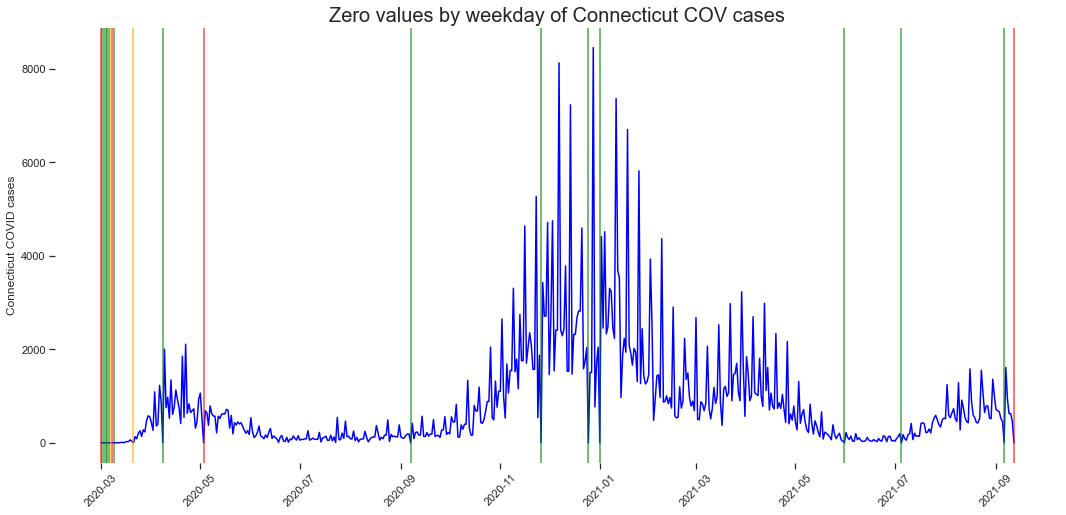

In [71]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['CT_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Connecticut COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ct:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ct:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ct:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Connecticut COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

## Vermont

#### Monday

In [72]:
VT_monday_index_list = []
VT_monday_case_list = []
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-06-07')) & (index <=pd.Timestamp('2021-08-24'))&(row['weekday']==0) & (row['VT_Conf_Cases'] != 0):
        VT_monday_index_list.append(index)
        row['VT_Conf_Cases'] = (round(row['VT_Conf_Cases']/3))
        VT_monday_case_list.append(row['VT_Conf_Cases'])

#### Sunday

In [73]:
VT_sunday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-06-01')) & (index<= pd.Timestamp('2021-08-24')) & (row['weekday']==6) & (row['VT_Conf_Cases']==0):
        VT_sunday_index_list.append(index)       

In [74]:
VT_sunday_dict = dict(zip(VT_sunday_index_list, VT_monday_case_list))

In [75]:
for key, value in VT_sunday_dict.items():
    df9['VT_Conf_Cases'].loc[key] = value

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


#### Saturday

In [76]:
VT_saturday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-06-01')) & (index<= pd.Timestamp('2021-08-24')) & (row['weekday']==5) & (row['VT_Conf_Cases']==0):
        VT_saturday_index_list.append(index)

In [77]:
VT_saturday_dict= dict(zip(VT_saturday_index_list, VT_monday_case_list))

In [78]:
for key, value in VT_saturday_dict.items():
    df9['VT_Conf_Cases'].loc[key] = value

In [79]:
sunday_ind_vt=(df9[(df9.weekday == 6)&(df9.VT_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_vt=(df9[(df9.weekday == 5)&(df9.VT_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_vt=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.VT_Conf_Cases==0)]).index

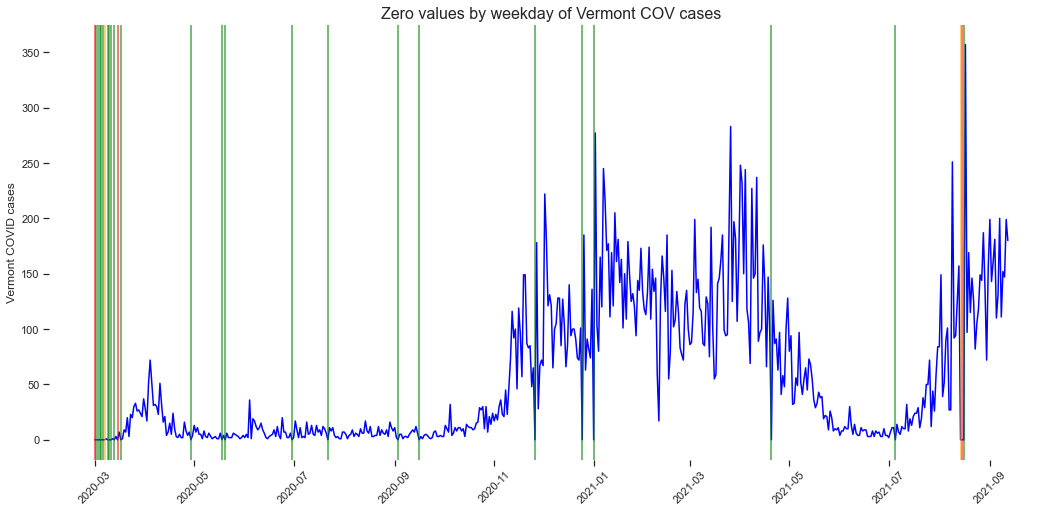

In [80]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['VT_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Vermont COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_vt:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_vt:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_vt:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Vermont COV cases', fontsize=16)
    sns.despine(left=True, bottom=True)
    plt.show()

## Massachusetts

#### Monday

In [81]:
MA_monday_index_list = []
MA_monday_case_list = []
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-07-01')) & (row['weekday']==0) &(row['MA_Conf_Cases'] != 0):
        MA_monday_index_list.append(index)
        row['MA_Conf_Cases'] = round(row['MA_Conf_Cases']/3)
        MA_monday_case_list.append(row['MA_Conf_Cases'])

#### Sunday

In [82]:
MA_sunday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['MA_Conf_Cases']==0):
        MA_sunday_index_list.append(index)

In [83]:
MA_sunday_dict = dict(zip(MA_sunday_index_list, MA_monday_case_list))

In [84]:
for key, value in MA_sunday_dict.items():
    df9['MA_Conf_Cases'].loc[key] = value

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [85]:
MA_sunday_index_list2 = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-07-01')) & (row['weekday']==6) & (row['MA_Conf_Cases']==0):
        MA_sunday_index_list2.append(index)

In [86]:
MA_sunday_dict2 = dict(zip(MA_sunday_index_list2, MA_monday_case_list))

In [87]:
for key, value in MA_sunday_dict2.items():
    df9['MA_Conf_Cases'].loc[key] = value

#### Saturday

In [88]:
MA_saturday_index_list = []
for index, row in df9.iterrows():
    if (index>= pd.Timestamp('2021-06-01')) & (index<= pd.Timestamp('2021-08-24')) & (row['weekday']==5) & (row['MA_Conf_Cases']==0):
        MA_saturday_index_list.append(index)

In [89]:
MA_saturday_dict= dict(zip(MA_saturday_index_list, MA_monday_case_list))

In [90]:
for key, value in MA_saturday_dict.items():
    df9['MA_Conf_Cases'].loc[key] = value

In [91]:
MA_monday_index_list2 = []
MA_monday_case_list2 = []
for index, row in df9.iterrows():
    if (index >=pd.Timestamp('2021-08-27')) & (row['weekday']==0) &(row['MA_Conf_Cases'] != 0):
        MA_monday_index_list2.append(index)
        row['MA_Conf_Cases'] = round(row['MA_Conf_Cases']/3)
        MA_monday_case_list2.append(row['MA_Conf_Cases'])

In [92]:
MA_saturday_index_list2 = []
for index, row in df9.iterrows():
    if (index> pd.Timestamp('2021-07-01')) & (row['weekday']==5) & (row['MA_Conf_Cases']==0):
        MA_saturday_index_list2.append(index)

In [93]:
MA_saturday_dict2= dict(zip(MA_saturday_index_list2, MA_monday_case_list2))

In [94]:
for key, value in MA_saturday_dict2.items():
    df9['MA_Conf_Cases'].loc[key] = value

In [95]:
sunday_ind_ma=(df9[(df9.weekday == 6)&(df9.MA_Conf_Cases==0)]).index # Sunday zero values
saturday_ind_ma=(df9[(df9.weekday == 5)&(df9.MA_Conf_Cases==0)]).index # Saturday zero values
# Zero values that are neither Sunday nor Monday
other_ind_ma=(df9[(df9.weekday != 5)& (df9.weekday != 6)&(df9.MA_Conf_Cases==0)]).index 

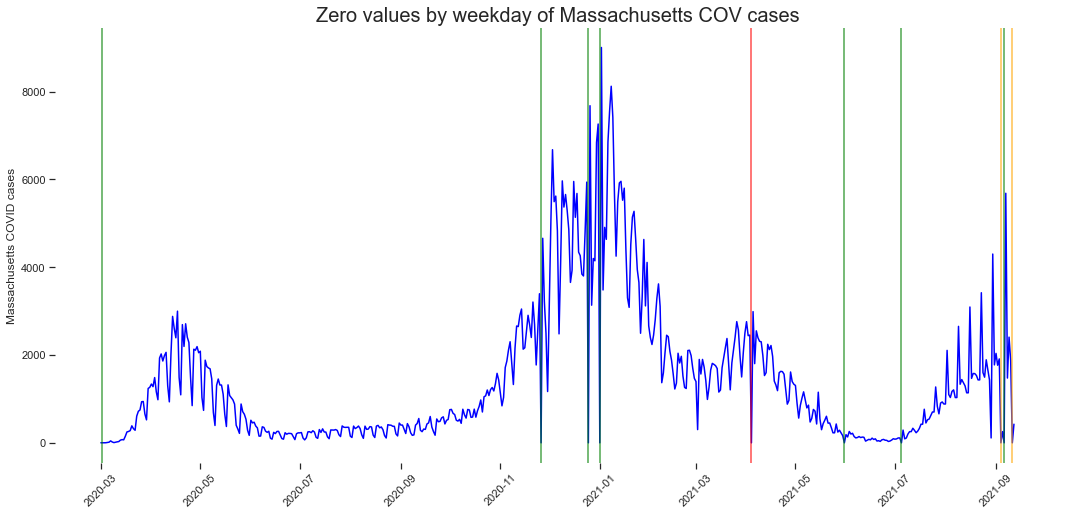

In [96]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    plt.plot(df9.index, df9['MA_Conf_Cases'], color = 'blue')
    ax.set_ylabel('Massachusetts COVID cases')
    plt.xticks(rotation=45)
    for i in sunday_ind_ma:    
        ax.axvline(x=i, color='red', alpha=0.7)
    for i in saturday_ind_ma:    
        ax.axvline(x=i, color='orange', alpha=0.7)
    for i in other_ind_ma:    
        ax.axvline(x=i, color='green', alpha=0.7)
    plt.title('Zero values by weekday of Massachusetts COV cases', fontsize=20)
    sns.despine(left=True, bottom=True)
    plt.show()

Another quick check of the summary statistics:

In [ ]:
#df6.describe()

Now the missing weekend values have been addressed, I'll identify US bank holidays that have missing values (presumably due to hospitals and reporting stations being closed). I won't remove any dates prior to the first known COVID cases in each state 

In [ ]:
#Create a list of US bank holidays in 2020-2021:
#Please refer to note below, explaining how this list of dates was put together.
#US_bank_holidays = ['2020-02-17', '2020-12-25', '2020-11-26', '2020-12-25', '2021-01-01', '2021-05-31', '2021-09-06']

Full list of 2020 US Holidays [here](https://www.officeholidays.com/countries/usa/2020).

Full list of 2021 US Holidays [here](https://www.officeholidays.com/countries/usa/2021).

__Note:__ Not all bank holidays listed in the above resources appear in my `US_bank_holidays` list. I used the resources above as a general guide of dates that might not contain any data, and then checked each of the dates individually to make sure I wasn't deleting any significant data from the set. I found that data __was__ recorded for some of the bank holidays listed in the resources; whenever this was the case, I did __not__ drop that row of data. The dates listed in `US_bank_holidays` reflect only those bank holidays listed in these resources that I was __also__ able to confirm did not have any significant data.

In [ ]:
#Drop rows with indices in US_bank_holidays list:
#df7= df6.drop(df6[(df6.index.isin(US_bank_holidays))].index)
#df7=df6

In [ ]:
#Check rows have been dropped:
#print(len(df6.index))
#print(len(df7.index))

In [ ]:
#Recheck summary statistics with dropped US_bank_holidays:
#df7.describe()

In [97]:
# save the data to a new csv file
df9.to_csv('state_cov_weather2.csv')

## Plots:

With so many twin axes to plot, I'll define a function to help plot all of twin axes time series data:

In [98]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
    axes.plot(x,y,color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y', colors = color)

## Connecticut

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

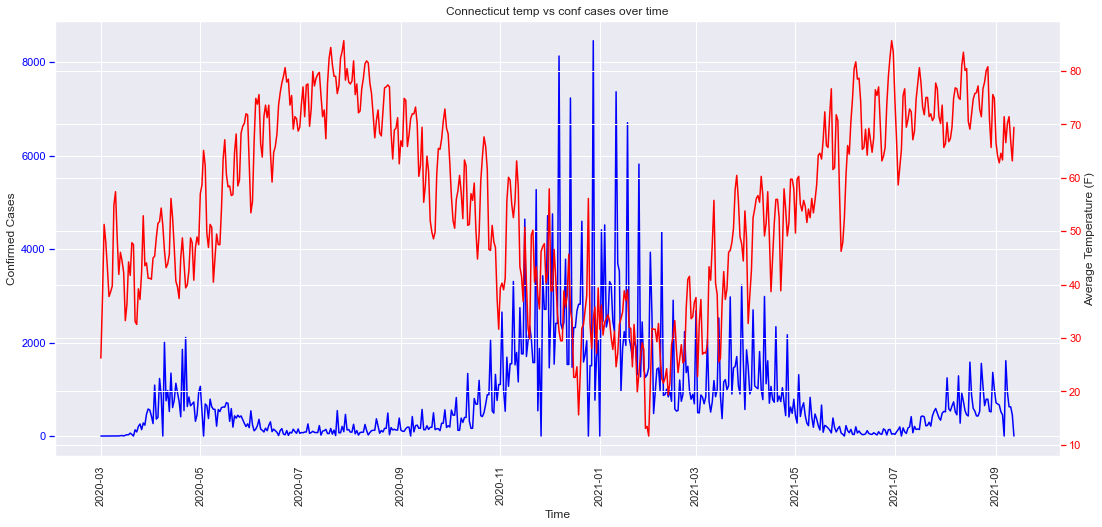

In [99]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT temp vs time
plot_timeseries(ax2, df9.index, df9['CT_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Connecticut temp vs conf cases over time')
plt.xticks(rotation=90)
plt.show()

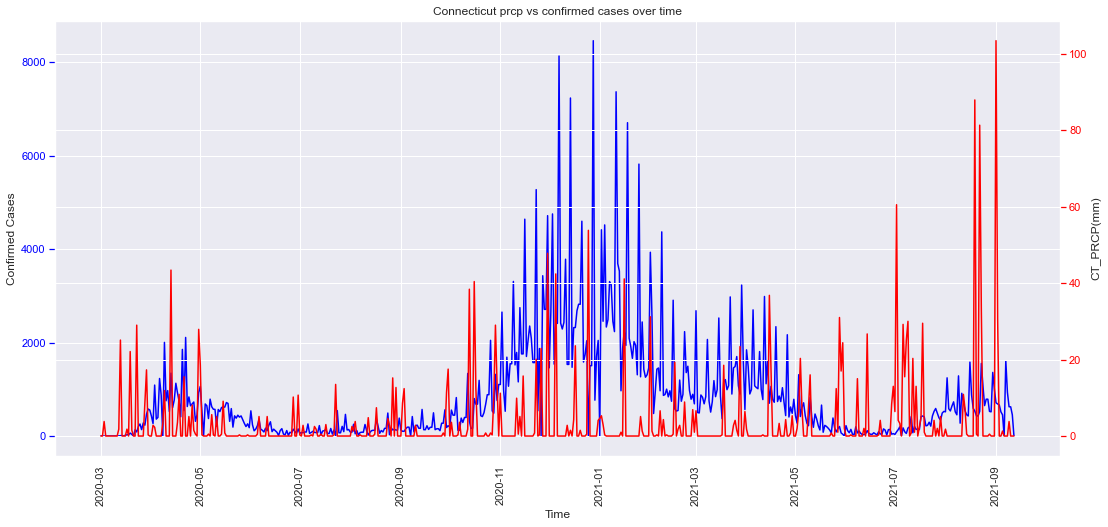

In [101]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT prcp vs time
plot_timeseries(ax2, df9.index, df9['CT_PRCP(mm)'], 'red', 'Time', 'CT_PRCP(mm)')
plt.title('Connecticut prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

***

## Maine

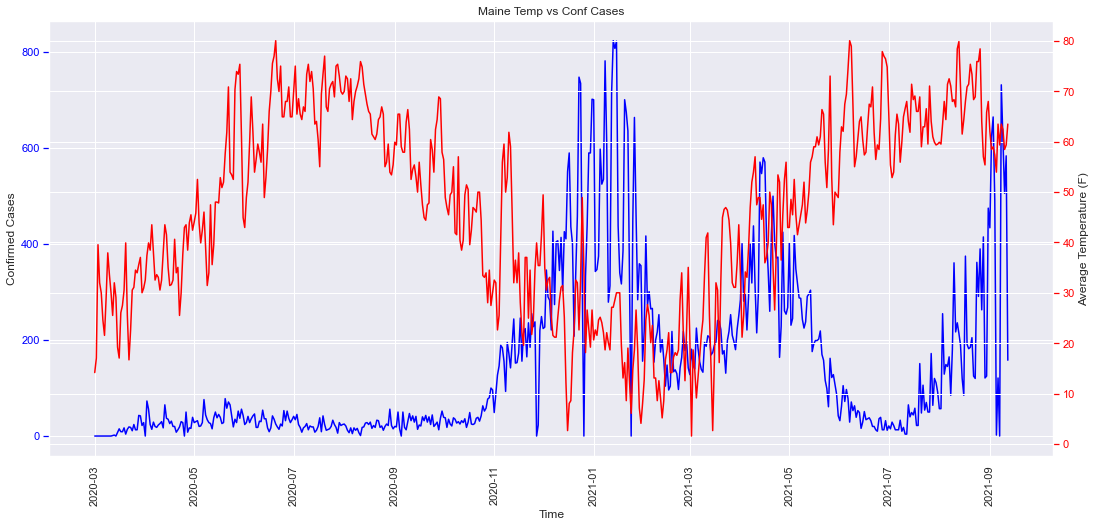

In [102]:
#Plot ME time vs Avg. Temp 
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
plot_timeseries(ax2, df9.index, df9['ME_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Maine Temp vs Conf Cases')
plt.xticks(rotation=90)
plt.show()

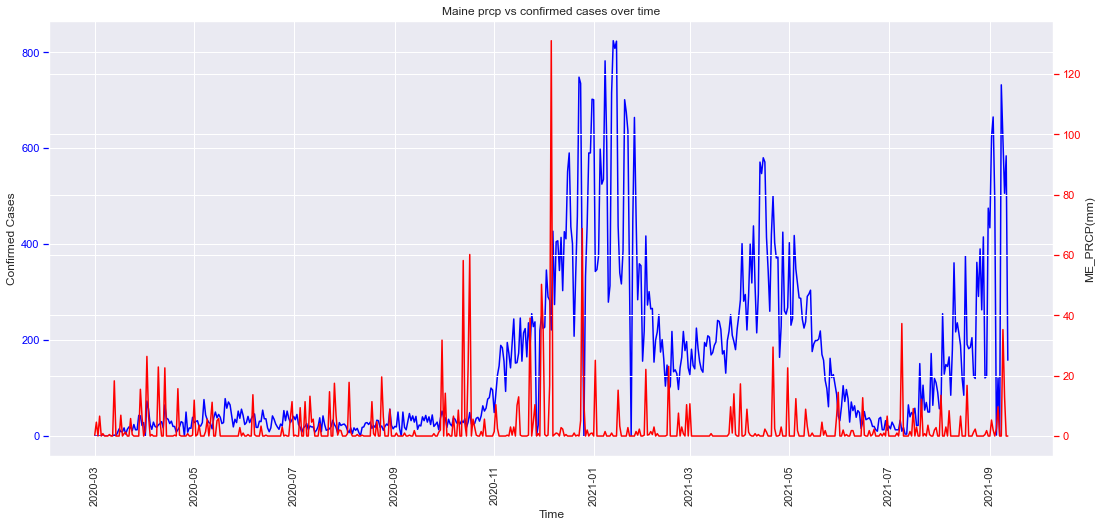

In [103]:
#Plot ME time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot ME prcp vs time
plot_timeseries(ax2, df9.index, df9['ME_PRCP(mm)'], 'red', 'Time', 'ME_PRCP(mm)')
plt.title('Maine prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Massachusetts

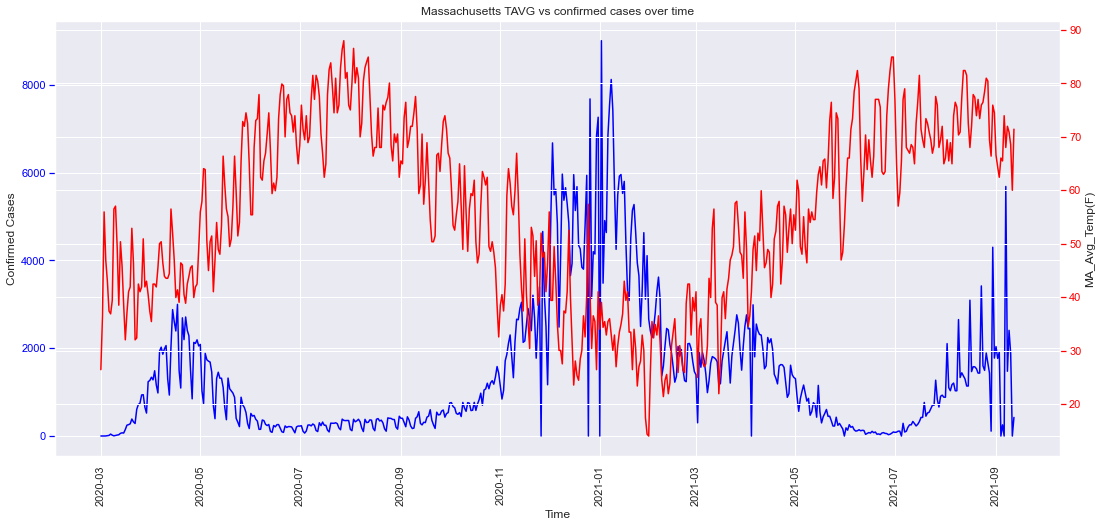

In [104]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA temp vs time
plot_timeseries(ax2, df9.index, df9['MA_Avg_Temp(F)'], 'red', 'Time', 'MA_Avg_Temp(F)')
plt.title('Massachusetts TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

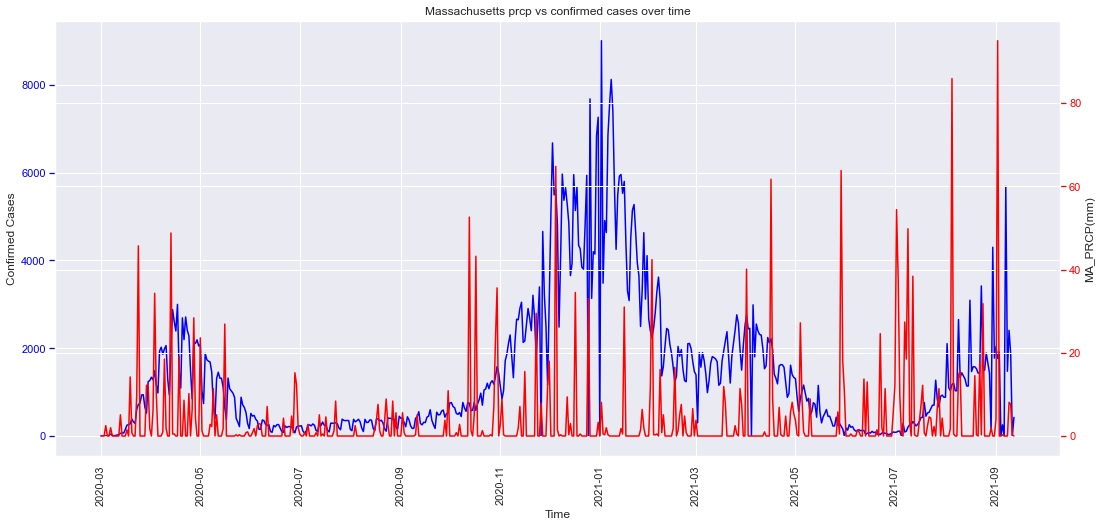

In [105]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df9.index, df9['MA_PRCP(mm)'], 'red', 'Time', 'MA_PRCP(mm)')
plt.title('Massachusetts prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Vermont

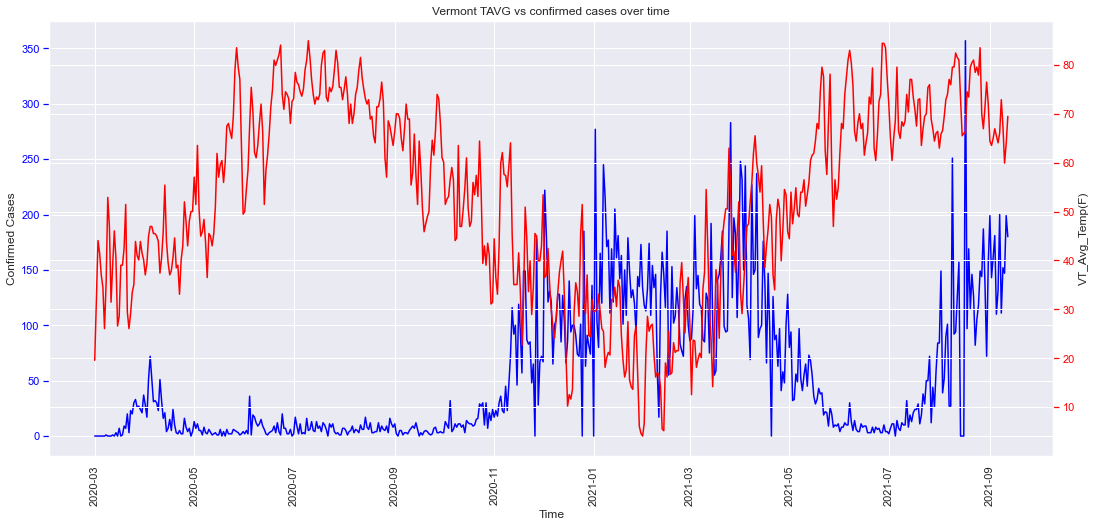

In [106]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot VT temp vs time
plot_timeseries(ax2, df9.index, df9['VT_Avg_Temp(F)'], 'red', 'Time', 'VT_Avg_Temp(F)')
plt.title('Vermont TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

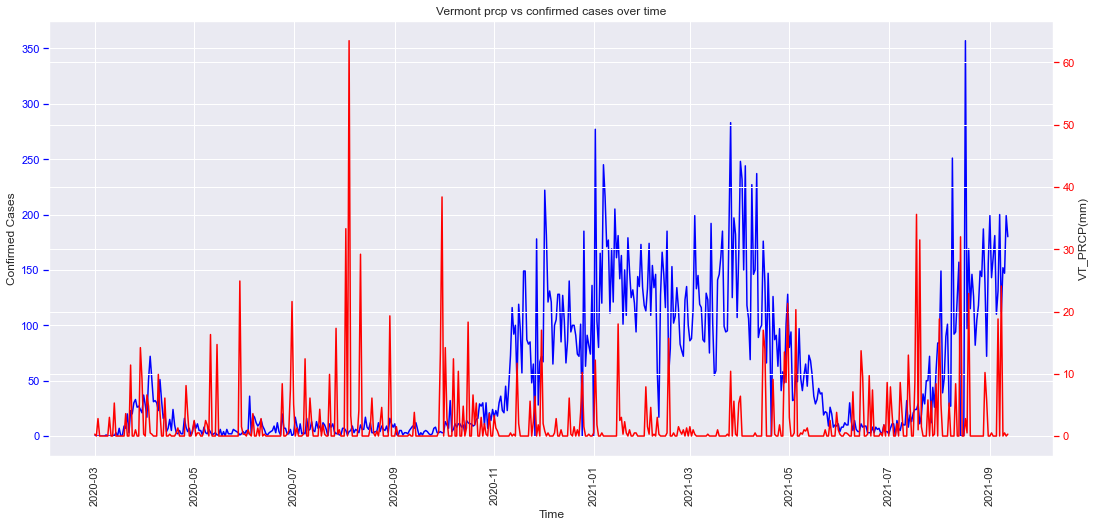

In [107]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df9.index, df9['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df9.index, df9['VT_PRCP(mm)'], 'red', 'Time', 'VT_PRCP(mm)')
plt.title('Vermont prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Perform Shapiro-Wilk test for normality:

In [108]:
#Convert dataframe to array to perform Shapiro-Wilcox test:
np_cov_weather9 = df9.to_numpy()

In [109]:
#Apply Shapiro test:
shapiro_test = stats.shapiro(np_cov_weather9)

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [110]:
#Print values:
print("Shapiro test statistic is: ", shapiro_test.statistic)
print("Shapiro p-value is: ", shapiro_test.pvalue)

Shapiro test statistic is:  0.3176637291908264
Shapiro p-value is:  0.0


## Predictive Power Score:

In [111]:
#Calculate ppscore 
pps = ppscore.matrix(df9)

In [112]:
print(pps)

                  x               y   ppscore            case  is_valid_score  \
0    VT_Avg_Temp(F)  VT_Avg_Temp(F)  1.000000  predict_itself            True   
1    VT_Avg_Temp(F)     VT_PRCP(mm)  0.000000      regression            True   
2    VT_Avg_Temp(F)  ME_Avg_Temp(F)  0.780311      regression            True   
3    VT_Avg_Temp(F)     ME_PRCP(mm)  0.000000      regression            True   
4    VT_Avg_Temp(F)  CT_Avg_Temp(F)  0.690918      regression            True   
..              ...             ...       ...             ...             ...   
164         weekday   CT_Conf_Cases  0.000000      regression            True   
165         weekday   VT_Conf_Cases  0.000000      regression            True   
166         weekday   ME_Conf_Cases  0.000000      regression            True   
167         weekday   MA_Conf_Cases  0.000000      regression            True   
168         weekday         weekday  1.000000  predict_itself            True   

                  metric  b

In [113]:
print(df9.dtypes)

VT_Avg_Temp(F)    float64
VT_PRCP(mm)       float64
ME_Avg_Temp(F)    float64
ME_PRCP(mm)       float64
CT_Avg_Temp(F)    float64
CT_PRCP(mm)       float64
MA_Avg_Temp(F)    float64
MA_PRCP(mm)       float64
CT_Conf_Cases     float64
VT_Conf_Cases     float64
ME_Conf_Cases     float64
MA_Conf_Cases     float64
weekday             int64
dtype: object


In [114]:
matrix_df = ppscore.matrix(df9).pivot(columns='x', index='y',  values='ppscore')

<AxesSubplot:xlabel='x', ylabel='y'>

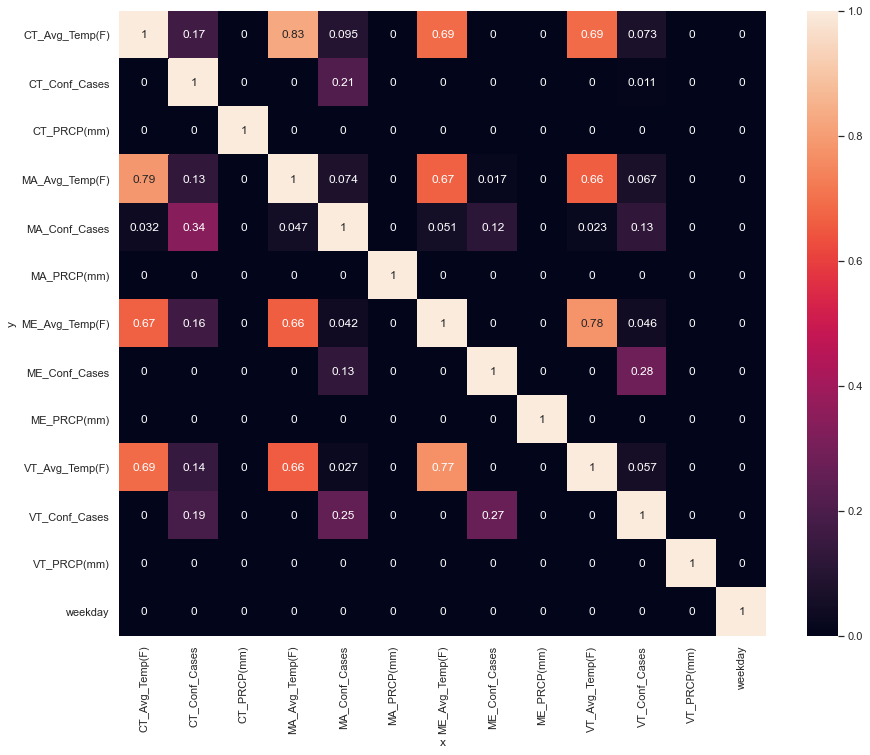

In [115]:
sns.set(rc={'figure.figsize':(14.5,11.5)})
sns.heatmap(matrix_df, annot= True)

<AxesSubplot:>

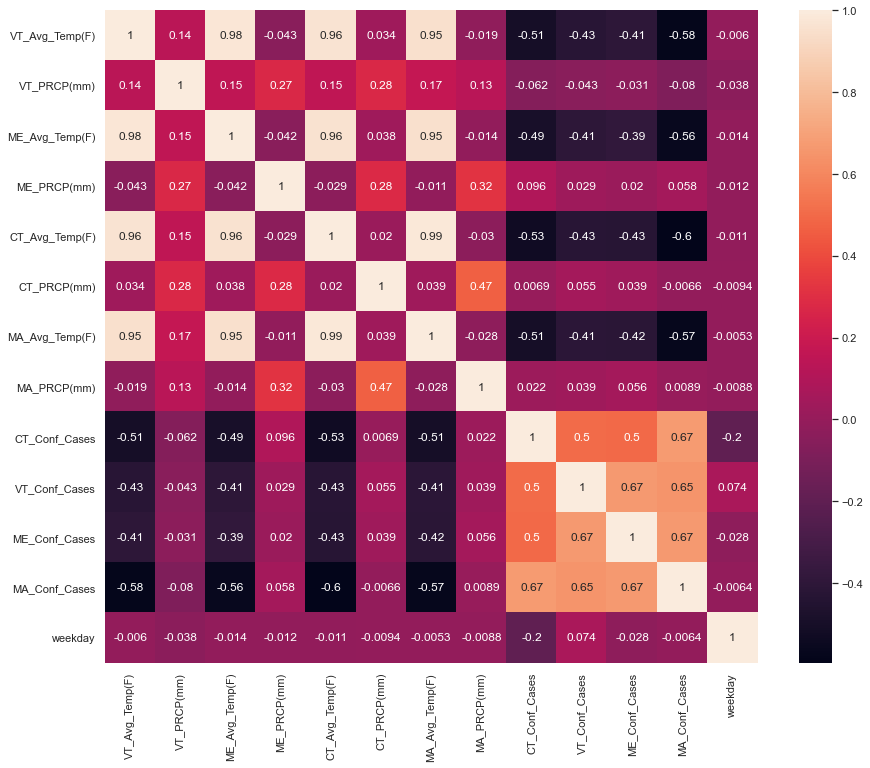

In [116]:
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(df9.corr(), square=True, annot=True)
#cmap='rocket'
#(11.7,8.27)

In [117]:
CT = df9[['CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases']]

<AxesSubplot:>

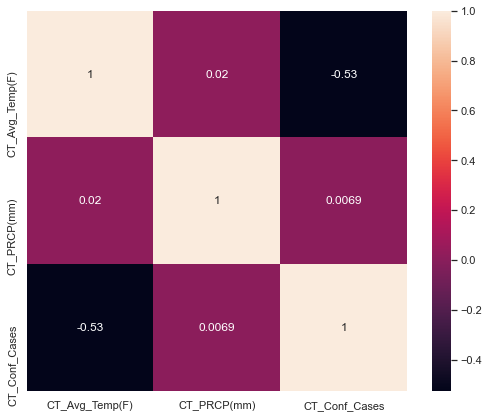

In [118]:
sns.set(rc={'figure.figsize':(9,7)})
sns.heatmap(CT.corr(), square=True, cmap='rocket', annot = True)

In [119]:
MA = df9[['MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases']]

<AxesSubplot:>

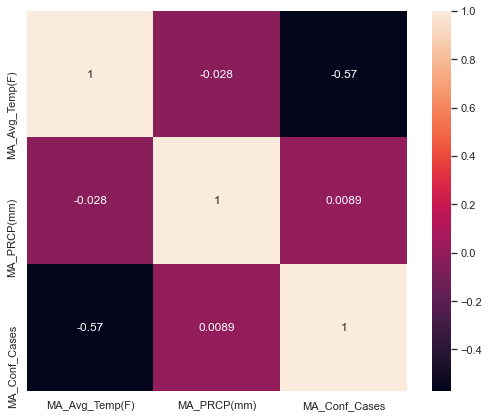

In [120]:
sns.heatmap(MA.corr(), square=True, cmap='rocket', annot=True)

In [121]:
VT= df9[['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases']]

<AxesSubplot:>

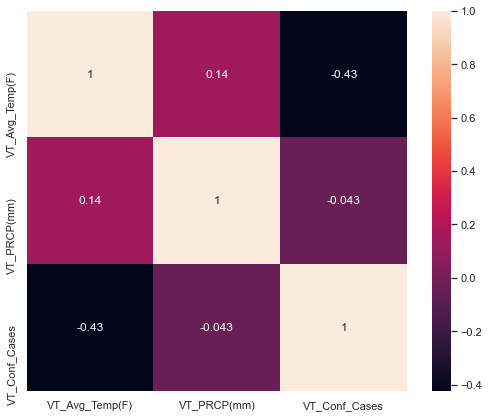

In [122]:
sns.heatmap(VT.corr(), square=True, cmap='rocket', annot=True)

In [123]:
ME = df9[['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases']]

<AxesSubplot:>

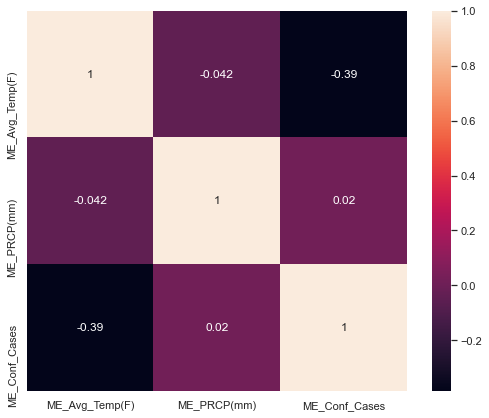

In [124]:
sns.heatmap(ME.corr(), square=True, cmap='rocket', annot=True)